In [ ]:
cd /content/drive/MyDrive/Sommer\ Group/AnalysisCode

/content/drive/MyDrive/Sommer Group/AnalysisCode


In [ ]:
pwd

'/content/drive/MyDrive/Sommer Group/AnalysisCode'

In [ ]:
import sys
# sys.path.append(r'C:\Users\Sommer Lab\Documents\Analysis Code')
import os
from scipy.optimize import curve_fit
from scipy.ndimage import rotate
from scipy.integrate import simpson

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from ImageAnalysis import ImageAnalysisCode
from scipy import signal


In [ ]:
xx = np.arange(100)

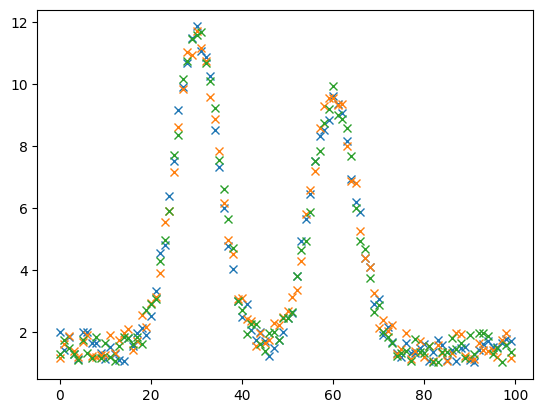

In [ ]:
yy = []
y = ImageAnalysisCode.MultiGaussian(xx, 10, 8, 30, 60, 5, 5, 1)

for ii in range(3):
  yy.append(y + np.random.random(100) )

yy = np.array(yy).T
plt.plot(xx, yy, 'x')

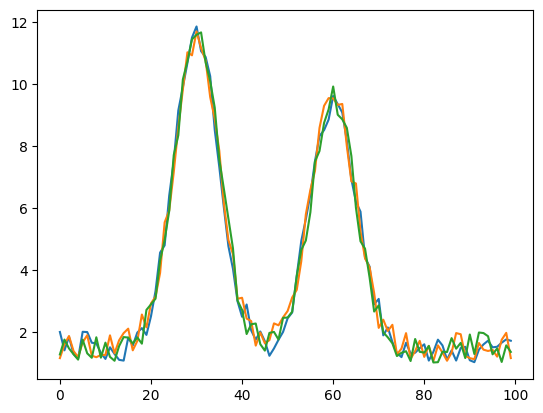

In [ ]:
plt.plot(yy)

In [ ]:
xxsh = xx.copy()
np.random.shuffle(xxsh)
yysh = yy[xxsh]

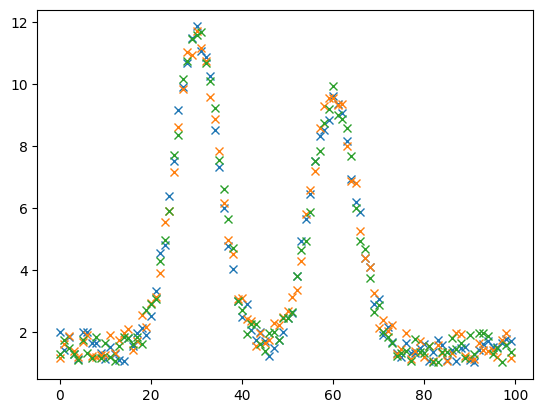

In [ ]:
plt.plot(xxsh, yysh, 'x')

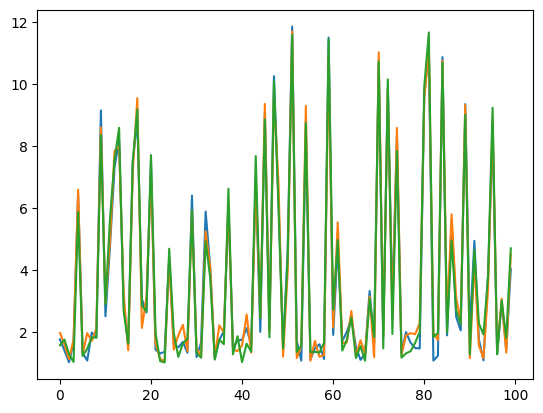

In [ ]:
plt.plot(yysh)

In [103]:
pp = fitMultiGaussian(yysh[:, 0], xdata=xxsh, guess=[10, 8, 30, 60, 5, 5, 2], peakplot=1)
pp[0]

array([10.23815581,  7.99569725, 29.91837602, 60.00748105,  4.84826738,
        5.08818923,  1.43980123])

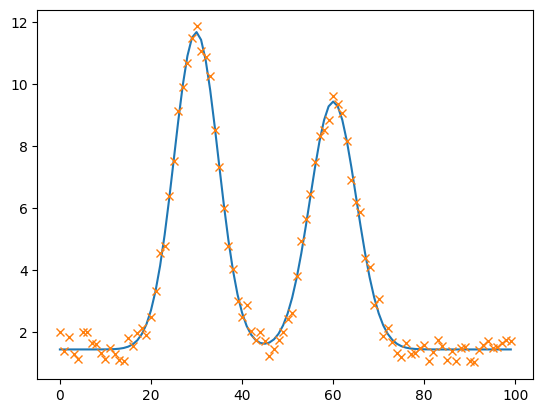

In [108]:
plt.plot(ImageAnalysisCode.MultiGaussian(xx, *pp[0]))
plt.plot(xxsh, yysh[:,0], 'x')

(array([10.23815564,  7.99569672, 29.91837624, 60.0074809 ,  4.84826795,
         5.08819044,  1.43980093]),
 None)

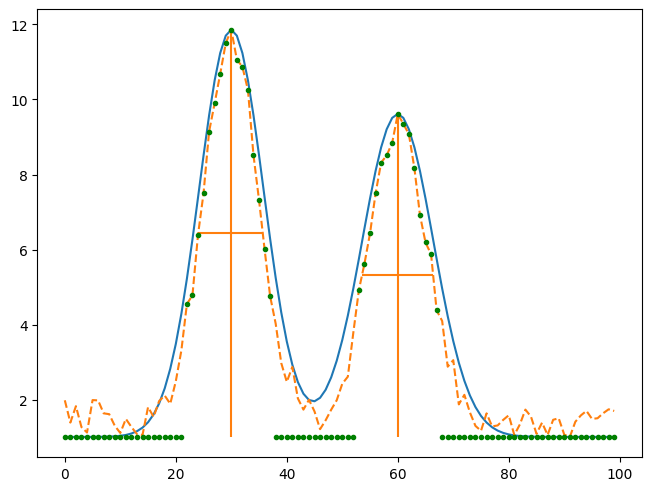

In [ ]:
fitMultiGaussian(yy[:, 0],  peakplot=1)

In [ ]:
peaks, properties = DetectPeaks(yy[:,0])

In [ ]:
properties

{'prominences': array([10.83799184,  8.59617838]),
 'left_bases': array([21, 52]),
 'right_bases': array([38, 68]),
 'widths': array([11.63540727, 12.82969646]),
 'width_heights': array([6.43819723, 5.3172905 ]),
 'left_ips': array([24.03836411, 53.54761641]),
 'right_ips': array([35.67377138, 66.37731287])}

In [109]:
properties['left_ips'] - properties['right_ips']

array([-11.63540727, -12.82969646])

In [ ]:
xxsh[peaks]

array([75, 19])

In [ ]:
def DetectPeaks(yy, xx=None, amp=1, width=3, denoise=0, doPlot=0):

    if xx is not None:
        x_unik = np.unique(xdata)

        y_unik = []
        for x in x_unik:
            y_unik = xdata[xdata==x].mean()

        xx = x_unik
        yy = y_unik

    if denoise:
        yycopy = gaussian_filter1d(yy, 5)
    else:
        yycopy = yy.copy()

    # Determine the background with the otsu method and set to 0.
    # thr = threshold_otsu(yycopy)
    thr = 0.3 * (yy.max() - yy.min()) + yy.min()
    yycopy[yycopy < thr] = yy.min()

    peaks, properties = signal.find_peaks(yycopy, prominence=amp*0.01*(yycopy.max()-yycopy.min()), width=width)

    if xx is not None:
        peaks = xx[peaks]



    if doPlot:
        fig, ax = plt.subplots(1,1, layout='constrained')

        ymin = yy[peaks] - properties["prominences"]
        ymax = yy[peaks]
        amp = ymax - ymin
        xmin = properties["left_ips"]
        xmax = properties["right_ips"]
        width = (xmax - xmin) / 2
        ax.vlines(x=peaks, ymin=ymin, ymax=ymax, color = "C1")
        ax.hlines(y=properties["width_heights"], xmin=xmin, xmax=xmax, color = "C1")
        xx = np.arange(len(yy))
        ax.plot(xx, MultiGaussian(xx, *amp, *peaks, *width, yy.min()))
        ax.plot(yy, '--')
        ax.plot(yycopy, '.g')

    return peaks, properties

In [97]:
def fitMultiGaussian(data, xdata=None, dx=1, NoOfModel='auto', guess=[],
                     subtract_bg=0, signal_feature='wide', signal_width=10, fitbgDeg=5,
                     amp=1, width=3, denoise=0, peakplot=0):

    if subtract_bg:
        bg = fitbg(data, signal_feature=signal_feature, signal_width=signal_width, fitbgDeg=fitbgDeg)
        data = data - bg
        offset = 0
    else:
        offset = min( data[:10].mean(), data[-10:].mean() )
        bg = None

    if not guess:
        peaks, properties = DetectPeaks(data, amp, width, denoise, doPlot=peakplot)

        #initial guess:
        amps = properties['width_heights'] + properties['prominences'] / 2
        widths = (properties['right_ips'] - properties['left_ips']) / 2

        N = len(peaks)
        # print(peaks)

        if NoOfModel != 'auto' and NoOfModel > N:
            D = NoOfModel - N
            N = NoOfModel
            amps = np.concatenate( (amps, [amps.mean()]*D) )
            peaks = np.concatenate( (peaks, [int(amps.mean()-20)]*D) )
            widths = np.concatenate( (widths, [int(widths.mean())]*D) )

        guess = [*amps, *peaks, *widths, offset]

    else:
        N = len(guess) // 3

    if xdata is None:
        xdata = np.arange( len(data) )

    try:
        # minamps = 0.1*(data.max()-data.min())
        minamps = 0
        popt, _ = curve_fit(ImageAnalysisCode.MultiGaussian, xdata, data, p0 = guess,
                            bounds=([minamps]*N + [0]*N + [3]*N + [-np.inf], [np.inf]*(3*N+1)))

    except Exception as e:
        print(e)
        return None, None

    popt[N:-1] *= dx

    return popt, bg